(42535, 4)


In [22]:
from IoU import bb_intersection_over_union
import numpy as np
import time
import pandas as pd

Predicted_Data = pd.read_pickle('RCNN_Predicted_Data.pkl')
True_Data = pd.read_pickle('RCNN_True_Data.pkl')
Predicted_Data.sort_values(['pred_scores'], axis=0, ascending=False, inplace=True)
Predicted_Data.reset_index(inplace=True)
n_pred = Predicted_Data.shape[0]
Predicted_Data = Predicted_Data.take(np.linspace(0, n_pred-1, num=100), axis=0)
#print(Predicted_Data[:4])
#print(True_Data['true_labels'].value_counts())
def calc_precision_recall(Predicted_Data, True_Data, class_labels):
    Predicted_Data.sort_values(['pred_scores'], axis=0, ascending=False, inplace=True)
    Predicted_Data.reset_index(inplace=True)
    n_classes = len(class_labels)
    mAP_thresh = 0.5
    
    n_pred = Predicted_Data.shape[0]
    Precision = np.zeros((n_pred))
    Recall = np.zeros((n_pred))
    TP_FN = True_Data['true_labels'].value_counts()
    for p in range(1,n_pred+1):
        #start_time = time.time()
        pred_data = Predicted_Data[:p]
        class_precision = []
        class_recall = []
        for c in range(n_classes):
            if  not(TP_FN.keys().contains(c)):
                continue
            cl = class_labels[c]
            pred_data_cl = pred_data.loc[pred_data['pred_labels'] == cl]
            n_bboxes = pred_data_cl.shape[0]
            TP = 0
            FP = 0
            # Check if positives are True or False
            for _,pred_row in pred_data_cl.iterrows():
                pred_bbox = pred_row['pred_bboxes']
                img_num = pred_row['img_num']
                true_data = True_Data.loc[True_Data['img_num'] == img_num]
                true_data = true_data.loc[true_data['true_labels'] == cl]
                n_true_bboxes = true_data.shape[0]
                # Calculate iou between ground truth and predictions
                max_iou = 0
                for _,true_row in true_data.iterrows():
                    true_bbox = true_row['true_bboxes']
                    iou = bb_intersection_over_union(pred_bbox, true_bbox)
                    if (iou > max_iou):
                        max_iou = iou
                if (max_iou >= mAP_thresh):
                    TP += 1
                elif (max_iou < mAP_thresh):
                    FP += 1
            if (n_bboxes > 0):
                class_precision.append(TP/(TP+FP))
                class_recall.append(TP/TP_FN[cl])
        Precision[p-1] = sum(class_precision)/len(class_precision)
        Recall[p-1] = sum(class_recall)/len(class_recall)
        #print(time.time() - start_time)
    
    return Precision, Recall

n_classes = 20
class_labels = [i for i in range(n_classes)]
Precision, Recall = calc_precision_recall(Predicted_Data, True_Data, class_labels)

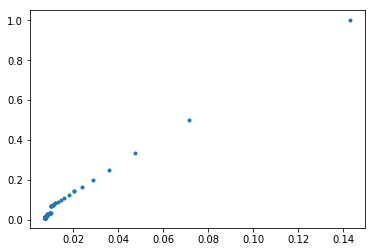

In [24]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(Recall, Precision, '.')


In [ ]:
n_classes = 20
class_labels = [i for i in range(n_classes)]
#True_Positives = np.zeros((n_classes))
#False_Positives = np.zeros((n_classes))
#False_Negatives = np.zeros((n_classes))
for minibatch_count, (img, true_bboxes, true_labels) in enumerate(test_loader, 0):
    print(true_bboxes.shape, true_labels.shape)
    pred_bboxes, pred_labels, pred_scores = trainer.faster_rcnn.predict(img,visualize=False, score_thresh=0.7)
    true_bboxes, true_labels = true_bboxes.numpy()[0], true_labels.numpy()[0]
    pred_bboxes, pred_labels = np.asarray(pred_bboxes)[0], np.asarray(pred_labels)[0]
    TP, FP, FN = calc_TP_FP_FN((true_bboxes, true_labels), (pred_bboxes, pred_labels), class_labels)
    True_Positives = np.add(True_Positives, TP)
    False_Positives = np.add(False_Positives, FP)
    False_Negatives = np.add(False_Negatives, FN)
    #print(minibatch_count)
    if minibatch_count > 1000:
        break

Precision = np.zeros((n_classes))
Recall = np.zeros((n_classes))
for i in range(n_classes):
    if (True_Positives[i] + False_Positives[i]) != 0:
        Precision[i] = True_Positives[i]/(True_Positives[i] + False_Positives[i])
    if (True_Positives[i] + False_Negatives[i]) != 0:
        Recall[i] = True_Positives[i]/(True_Positives[i] + False_Negatives[i])
#np.divide(TP, np.add(TP, FP))
#np.divide(TP, np.add(TP, FN))
print(Precision)
print(Recall)

#start_time = time.time()
#print(time.time() - start_time)

In [ ]:
print(len(test_loader)*elapsed_time/3600)

In [ ]:
### WRONG WAY ###

n_classes = 20
class_labels = [i for i in range(n_classes)]
#True_Positives = np.zeros((n_classes))
#False_Positives = np.zeros((n_classes))
#False_Negatives = np.zeros((n_classes))
score_thresh = [0.2, 0.4, 0.6, 0.8]
Total_P = []
Total_R = []
for thresh in score_thresh:
    for minibatch_count, (img, true_bboxes, true_labels) in enumerate(test_loader, 0):
        pred_bboxes, pred_labels, pred_scores = trainer.faster_rcnn.predict(img,visualize=False, score_thresh=thresh)
        true_bboxes, true_labels = true_bboxes.numpy()[0], true_labels.numpy()[0]
        pred_bboxes, pred_labels = np.asarray(pred_bboxes)[0], np.asarray(pred_labels)[0]
        TP, FP, FN = calc_TP_FP_FN((true_bboxes, true_labels), (pred_bboxes, pred_labels), class_labels)
        True_Positives = np.add(True_Positives, TP)
        False_Positives = np.add(False_Positives, FP)
        False_Negatives = np.add(False_Negatives, FN)
        #print(minibatch_count)
        if minibatch_count > 100:
            break
    
    Precision = np.zeros((n_classes))
    Recall = np.zeros((n_classes))
    for i in range(n_classes):
        if (True_Positives[i] + False_Positives[i]) != 0:
            Precision[i] = True_Positives[i]/(True_Positives[i] + False_Positives[i])
        if (True_Positives[i] + False_Negatives[i]) != 0:
            Recall[i] = True_Positives[i]/(True_Positives[i] + False_Negatives[i])
    ave_precision = np.mean(Precision)
    ave_recall = np.mean(Recall)
    Total_P.append(ave_precision)
    Total_R.append(ave_recall)
    print('For score_thresh=%.2f, Precision=%.2f, Recall=%.2f' %(thresh, ave_precision, ave_recall))

#np.divide(TP, np.add(TP, FP))
#np.divide(TP, np.add(TP, FN))
print(Precision)
print(Recall)


Precision = np.zeros((n_classes))
Recall = np.zeros((n_classes))
for i in range(n_classes):
    if (True_Positives[i] + False_Positives[i]) != 0:
        Precision[i] = True_Positives[i]/(True_Positives[i] + False_Positives[i])
    if (True_Positives[i] + False_Negatives[i]) != 0:
        Recall[i] = True_Positives[i]/(True_Positives[i] + False_Negatives[i])
#np.divide(TP, np.add(TP, FP))
#np.divide(TP, np.add(TP, FN))
print(Precision)
print(Recall)
#images = 2*images/255 -1

In [ ]:
from IoU import bb_intersection_over_union
import numpy as np
import time
# loop over images
def calc_TP_FP_FN(true_vals, predicted_vals, class_labels):
    true_bbooxes, true_labels = true_vals
    predicted_bboxes, predicted_labels = predicted_vals
    mAP_thresh = 0.5
    n_classes = len(class_labels)
    TP = np.zeros((n_classes))
    FP = np.zeros((n_classes))
    FN = np.zeros((n_classes))
    n_pred_bboxes = predicted_bboxes.shape[0]
    for c in class_labels:
        class_ind = (true_labels == c)
        n_bboxes = np.sum(class_ind)
        class_bboxes = true_bbooxes[class_ind]
        for b in range(n_bboxes):
            # Calculate iou between ground truth and predictions
            iou = np.zeros((n_pred_bboxes))
            for pb in range(n_pred_bboxes):
                iou[pb] = bb_intersection_over_union(class_bboxes[b], predicted_bboxes[pb])
            # Calculate True Positives
            n_true_pos = np.sum(np.logical_and(predicted_labels == c, iou >= mAP_thresh))
            if n_true_pos == 1:
                TP[c] += 1
            elif n_true_pos > 1:
                TP[c] += 1
                FP[c] += n_true_pos - 1
            else:
                FN[c] += 1
            # Calculate False Positives
            n_false_pos = np.sum(np.logical_and(predicted_labels != c, iou >= mAP_thresh))
            FP[c] += n_false_pos
            
    return (TP, FP, FN)

class_labels = [i for i in range(20)]

img, true_bboxes, true_labels = next(iter(test_loader))

pred_bboxes, pred_labels, pred_scores = trainer.faster_rcnn.predict(img,visualize=False, score_thresh=0.7)
true_bboxes, true_labels = true_bboxes.numpy()[0], true_labels.numpy()[0]
pred_bboxes, pred_labels = np.asarray(pred_bboxes)[0], np.asarray(pred_labels)[0]


calc_TP_FP_FN((true_bboxes, true_labels), (pred_bboxes, pred_labels), class_labels)

# it takes .2 seconds to load data and .6 seconds to run prediction